<a href="https://colab.research.google.com/github/b-richins92/Cancer_Prediction_10x/blob/main/GL_HVG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Testing highly variable genes**
Will use scanpy's method for detecting highly variable genes

1. Load in 30k dataset with original labels
2. Select highly variable genes using seurat_v3 method
3. Get lists of top 100, 200, 500, 1,000, 2,000, 5,000, or all genes. Also do the same for randomly selected genes
4. Do train/test split (for now, use default sklearn method with 5-fold cross-validation)
5. Plot all evaluation metrics for all approaches



In [1]:
# Install packages
!pip install scanpy[skmisc]

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 6.6 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=538504b1dc51fa8c97d024ccafe1153bda24599f3745d80afe196af1f5379510
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set up paths to files
main_dir = '/content/drive/MyDrive/_Course materials/S6 M2-4 699 - Capstone/'
data_path = '/content/drive/MyDrive/_Course materials/S6 M2-4 699 - Capstone/Capstone - Shared folder/Data/'

# Change into correct directory for importing custom preprocessing function
%cd {main_dir}scripts/
# %pwd

/content/drive/MyDrive/_Course materials/S6 M2-4 699 - Capstone/scripts


In [4]:
from main_functions import *
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from sklearn import set_config
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedGroupKFold, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score,\
                            balanced_accuracy_score, matthews_corrcoef, roc_auc_score, RocCurveDisplay, auc, average_precision_score, make_scorer

In [5]:
# Constants
random_state = 42
CV = 5

In [6]:
# Load in 30k dataset
adata_30k = create_adata(data_path + 'BRCA_EMTAB8107_expression.h5', data_path + 'BRCA_EMTAB8107_CellMetainfo_table.tsv')
adata_30k_df = adata_30k.to_df()

# Load in original labels and merge with TISCH counts
emtab_meta = pd.read_csv(data_path + 'EMTAB8107_2103-Breastcancer_metadata.csv.gz')
emtab_meta.set_index('Cell', inplace = True)
emtab_meta['orig_cancer_label'] = np.where(emtab_meta['CellType'] == 'Cancer', 1, 0)

# Merge original metadata with TISCH metadata
adata_30k.obs = pd.merge(adata_30k.obs, emtab_meta['orig_cancer_label'], left_index = True, right_index = True, how = 'inner')
print(f'Original # cells: {len(emtab_meta)}, TISCH # cells: {adata_30k.n_obs}, merged # cells: {len(adata_30k.obs)}')
display(adata_30k.obs.head())

Number of cells: 33043
Number of features: 22835
564.07 MB
Original # cells: 44024, TISCH # cells: 33043, merged # cells: 33043


,cancer_label,cell_type_malignancy,cell_type_major,cell_type_minor,Patient,Sample,patient_id,orig_cancer_label
sc5rJUQ024_AAACCTGGTCTCCACT,0,Immune cells,B,B,P41,Sample41,sc5rJUQ024,1
sc5rJUQ024_AAAGATGCAGCGAACA,0,Immune cells,B,B,P41,Sample41,sc5rJUQ024,0
sc5rJUQ024_AACCATGTCCTAGTGA,0,Immune cells,B,B,P41,Sample41,sc5rJUQ024,0
sc5rJUQ024_AACTCAGGTGTGACCC,0,Immune cells,B,B,P41,Sample41,sc5rJUQ024,0
sc5rJUQ024_AAGACCTGTCCGTGAC,0,Immune cells,B,B,P41,Sample41,sc5rJUQ024,0


In [14]:
# Identify highly variable genes using scanpy's seurat_v3 method (calculate z-normalized dispersion for genes binned by expression level)
# Set n_top_genes to total number of genes. Will then subset features
#adata_30k_hvg = sc.pp.highly_variable_genes(adata_30k, flavor='seurat_v3', n_top_genes=adata_30k.n_vars, inplace = False)
adata_30k_hvg = sc.pp.highly_variable_genes(bc_30k_sub, flavor='seurat_v3', n_top_genes=adata_30k.n_vars, inplace = False)
adata_30k_hvg = adata_30k_hvg.sort_values(by = 'highly_variable_rank')
# print(adata_30k_hvg.shape)
# print(adata_30k.n_vars)
# print(len(adata_30k_hvg[adata_30k_hvg['highly_variable'] == True]))
display(adata_30k_hvg.head())
display(adata_30k_hvg.tail())

,means,variances,gene_name,highly_variable_rank,variances_norm,highly_variable
IGKV1-17,16.336107,105965.143550,IGKV1-17,0.0,61.352590,True
IGKV3-20,28.433889,432484.679993,IGKV3-20,1.0,51.787726,True
IGHV3-21,11.503011,55875.792520,IGHV3-21,2.0,48.740997,True
IGHV3-23,14.878159,110509.208325,IGHV3-23,3.0,47.595868,True
IGKV1D-39,1.607965,1597.941577,IGKV1D-39,4.0,44.731458,True


,means,variances,gene_name,highly_variable_rank,variances_norm,highly_variable
RPL36AL,4.048906,17.192754,RPL36AL,22825.0,0.170199,True
SARAF,3.286354,11.260956,SARAF,22826.0,0.167872,True
RPS25,13.636111,154.515665,RPS25,22827.0,0.167794,True
PFDN5,5.102533,25.406955,PFDN5,22828.0,0.161393,True
FAU,13.022607,134.767814,FAU,22829.0,0.158284,True


In [ ]:
# Test HVGs using Cell Ranger method
adata_30k_hvg_cr = sc.pp.highly_variable_genes(adata_30k, flavor='cell_ranger', n_top_genes=adata_30k.n_vars, inplace = False)
adata_30k_hvg_cr = adata_30k_hvg_cr.sort_values(by = 'dispersions_norm', ascending = False)
display(adata_30k_hvg_cr.head())
display(adata_30k_hvg_cr.tail())

,means,dispersions,mean_bin,dispersions_norm,highly_variable
CTD-2516F10.2,0.392256,3.976381,"(0.262, 0.433]",37.585323,True
RP11-421M1.8,0.090190,3.814205,"(0.0736, 0.0928]",37.500028,True
CAPN15,0.097760,3.502799,"(0.0928, 0.117]",34.650976,True
ZNF789,0.380646,3.718880,"(0.262, 0.433]",34.356054,True
DMRT1,0.245258,3.279751,"(0.194, 0.262]",32.225399,True


,means,dispersions,mean_bin,dispersions_norm,highly_variable
RAVER1,3.685115,0.182180,"(0.433, 4.759]",-4.005728,True
WDR41,3.748433,0.170161,"(0.433, 4.759]",-4.077511,True
GRIN3A,4.410011,0.152883,"(0.433, 4.759]",-4.180709,True
LINC00519,4.002198,0.151361,"(0.433, 4.759]",-4.189799,True
RP11-575F12.3,4.186669,0.148708,"(0.433, 4.759]",-4.205640,True


In [34]:
# Test HVGs using seurat_v1 method

adata_30k_hvg_v1 = sc.pp.highly_variable_genes(adata_30k, flavor='seurat', n_top_genes=adata_30k.n_vars, inplace = False)
adata_30k_hvg_v1 = adata_30k_hvg_v1.sort_values(by = 'dispersions_norm', ascending = False)
display(adata_30k_hvg_v1.head())
display(adata_30k_hvg_v1.tail())

,means,dispersions,mean_bin,dispersions_norm,highly_variable
ZBTB11,0.171003,8.471698,"(-0.00513, 0.264]",14.195098,True
ZBED4,0.145741,8.247618,"(-0.00513, 0.264]",13.757165,True
CAP2,0.120641,8.214464,"(-0.00513, 0.264]",13.692370,True
RP11-431K24.4,0.203620,7.956273,"(-0.00513, 0.264]",13.187773,True
CARD19,0.079058,7.856384,"(-0.00513, 0.264]",12.992553,True


,means,dispersions,mean_bin,dispersions_norm,highly_variable
CPA3,0.000336,-0.537913,"(-0.00513, 0.264]",-3.412922,True
RP11-103H7.5,0.000318,-0.588635,"(-0.00513, 0.264]",-3.512050,True
GUCY1B3,0.000163,-0.614392,"(-0.00513, 0.264]",-3.562390,True
TMEM134,0.000259,-0.658976,"(-0.00513, 0.264]",-3.649523,True
CHD9,0.000156,-0.720104,"(-0.00513, 0.264]",-3.768989,True


In [11]:
num_features = [20, 50, 100, 200, 300, 400, 500, 1000, 2000, 5000, 10000]
rand_features_by_num = {}

# Choose random features - random order of all features, then choose subset for top features
rng = np.random.default_rng(random_state)
random_features = rng.choice(adata_30k.var_names, size = adata_30k.n_vars, replace=False)
print(len(random_features))

# Store random subsets of genes for each top N genes in a dictionary
for curr_num_feat in num_features:
  rand_features_by_num[curr_num_feat] = rng.choice(adata_30k.var_names, size = curr_num_feat, replace=False)
print(rand_features_by_num.keys())
rand_features_by_num[20]

22835
dict_keys([20, 50, 100, 200, 300, 400, 500, 1000, 2000, 5000, 10000])


array(['SNAI1', 'NUP50-AS1', 'SFXN2', 'C15orf54', 'ASIP',
       'RP11-508N22.12', 'URI1', 'TTLL10-AS1', 'ZNF559-ZNF177',
       'RP11-330A16.1', 'RBCK1', 'RP5-1057J7.7', 'HOXB13', 'TUBB1',
       'C9orf69', 'RP1-28O10.1', 'MYOT', 'IGLV5-45', 'SLC14A2', 'FBXO39'],
      dtype=object)

In [15]:
# Train/test split using standard sklearn method - train/test split by patient

# Defining variables
num_features = [20, 50, 100, 200, 300, 400, 500, 1000, 2000, 5000]
hvg_features = adata_30k_hvg.index
#hvg_features = adata_30k_hvg_cr.index
#hvg_features = adata_30k_hvg_v1.index

X = adata_30k_df
y = adata_30k.obs['orig_cancer_label']
groups = adata_30k.obs['Patient']
metrics_dict = {'accuracy': 'accuracy', 'balanced_accuracy': 'balanced_accuracy',
                'f1': 'f1', 'recall': 'recall', 'precision': 'precision',
                'average_precision': 'average_precision', 'roc_auc': 'roc_auc',
                'matthews_corrcoef': make_scorer(matthews_corrcoef)}

# Use dictionary to store folds
results_dict = {}
results_df = pd.DataFrame()

# Set up model - SVM
classifier = LinearSVC(random_state=random_state)

# 5-fold cross-validation (stratified, divided by patients) for SVM
sgkf = StratifiedGroupKFold(n_splits=5, shuffle = True, random_state = random_state)

# for i, (train_index, test_index) in enumerate(sgkf.split(X, y, groups)):
#     print(f"Fold {i}:")
#     print(f"  Train: group={groups[train_index].unique()}")
#     print(f"  Test:  group={groups[test_index].unique()}")

for curr_num_feat in num_features:
  print(f'curr_num_feat: {curr_num_feat}')

  # Get results for top N highly variable genes
  curr_results_hvg = cross_validate(classifier, X[hvg_features[:curr_num_feat]], y, groups = groups, scoring = metrics_dict,
                 cv = sgkf, return_train_score = True)
  curr_results_hvg['feature_type'] = 'hvg'
  curr_results_hvg['num_features'] = curr_num_feat
  results_df = pd.concat([results_df, pd.DataFrame.from_dict(curr_results_hvg)], ignore_index=True)

  # Get results for top N random genes
  # Regenerate random genes
#  random_features_new = rng.choice(adata_30k.var_names, size = curr_num_feat, replace=False)
  random_features_new = rand_features_by_num[curr_num_feat]

  # Classifier of top set of random genes
  curr_results_rand_top = cross_validate(classifier, X[random_features[:curr_num_feat]],
                                         y, groups = groups, scoring = metrics_dict,
                 cv = sgkf, return_train_score = True)
  curr_results_rand_top['feature_type'] = 'rand_top'
  curr_results_rand_top['num_features'] = curr_num_feat
  results_df = pd.concat([results_df, pd.DataFrame.from_dict(curr_results_rand_top)], ignore_index=True)

  # Classifier for new set of random genes
  curr_results_rand_new = cross_validate(classifier, X[random_features_new],
                                         y, groups = groups, scoring = metrics_dict,
                 cv = sgkf, return_train_score = True)
  curr_results_rand_new['feature_type'] = 'rand_new'
  curr_results_rand_new['num_features'] = curr_num_feat
  results_df = pd.concat([results_df, pd.DataFrame.from_dict(curr_results_rand_new)], ignore_index=True)

#  print(f'results_df.shape: {results_df.shape}')
#  display(results_df.tail())

results_df.to_csv(main_dir + 'scripts/results_df_seuratv3_rand_all_v2_rawcounts.csv')

curr_num_feat: 20
curr_num_feat: 50
curr_num_feat: 100
curr_num_feat: 200
curr_num_feat: 300
curr_num_feat: 400
curr_num_feat: 500
curr_num_feat: 1000
curr_num_feat: 2000
curr_num_feat: 5000


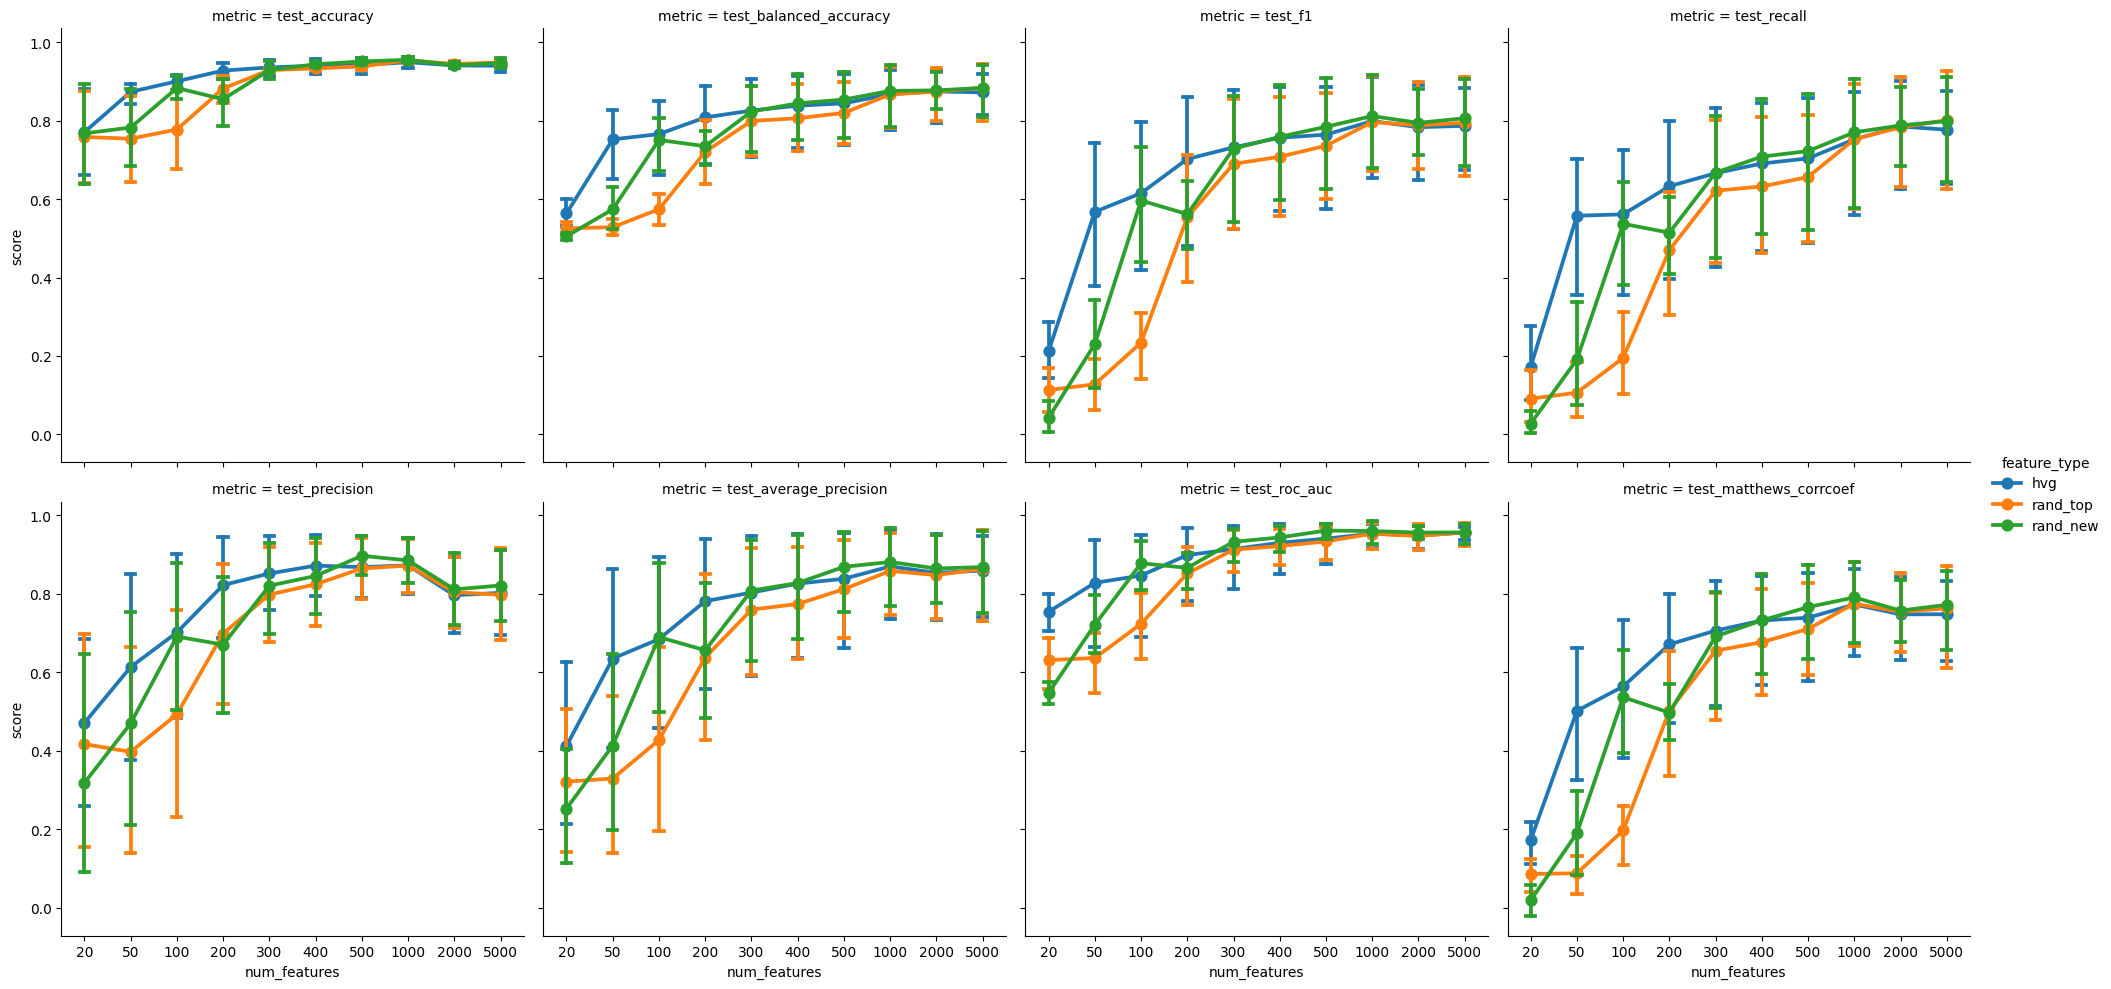

In [16]:
# Plot metrics vs number of features
# Compare for HVG vs random for test metrics, averaged across all 5 folds

#results_df = pd.read_csv(main_dir + 'scripts/results_df.csv')
#display(results_df.head())

# Convert to tall df - combine all metrics into 1 column
results_df_tall = results_df.melt(id_vars=['feature_type', 'num_features'], var_name='metric', value_name='score')
#display(results_df_tall.head())

# Add additional column for train or test, or just keep rows with 'test_' in metric name
results_sub = results_df_tall[results_df_tall['metric'].str.contains('test_')]

# Plot metric score versus number of features. Facet by metric. Color by feature type
g = sns.catplot(
    data=results_sub, x="num_features", y="score", col="metric",
    hue = "feature_type", kind="point", col_wrap = 4, capsize = 0.2
)



Majority of features don't overlap, even when # genes = 1000

In [17]:
# Get Jaccard coefficient between HVG and random genes
jaccard_df = pd.DataFrame(columns=['num_features', 'jaccard_coeff'])

# Jaccard coeff = (# common items in A&B) / (total # items in A&B)
for curr_num_feat in num_features:
  curr_hvg_set = set(hvg_features[:curr_num_feat])
  curr_rand_set = set(random_features[:curr_num_feat])
# To calculate Jaccard with random set of genes at each num, need to store set of features, or can regenerate since use random seed
  random_features_new = rng.choice(adata_30k.var_names, size = curr_num_feat, replace=False)
  curr_rand_new_set = set(random_features_new)

  curr_jaccard = len(curr_hvg_set.intersection(curr_rand_set)) / len(curr_hvg_set.union(curr_rand_set))
  jaccard_df = pd.concat([jaccard_df, pd.DataFrame({'num_features': [curr_num_feat], 'jaccard_coeff': [curr_jaccard], 'type': 'same set'})], ignore_index=True)

  curr_jaccard_rand_new = len(curr_hvg_set.intersection(curr_rand_new_set)) / len(curr_hvg_set.union(curr_rand_new_set))
  jaccard_df = pd.concat([jaccard_df, pd.DataFrame({'num_features': [curr_num_feat], 'jaccard_coeff': [curr_jaccard_rand_new], 'type': 'different set'})], ignore_index=True)

display(jaccard_df)
jaccard_df.to_csv(main_dir + 'scripts/jaccard_df_seuratv3_rand_all_v2_rawcounts.csv')

<ipython-input-17-0592f3619040>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  jaccard_df = pd.concat([jaccard_df, pd.DataFrame({'num_features': [curr_num_feat], 'jaccard_coeff': [curr_jaccard], 'type': 'same set'})], ignore_index=True)


,num_features,jaccard_coeff,type
0,20,0.000000,same set
1,20,0.000000,different set
2,50,0.000000,same set
3,50,0.000000,different set
4,100,0.000000,same set
5,100,0.005025,different set
6,200,0.002506,same set
7,200,0.002506,different set
8,300,0.005025,same set
9,300,0.005025,different set


In [7]:
# Test analytic Pearson residuals

# Load raw counts and subset to same cells and genes as TISCH
bc_30k_orig = sc.read_10x_mtx(data_path + 'EMTAB8107_2102-Breastcancer_counts', gex_only = False)
bc_30k_orig_df = bc_30k_orig.to_df()
print(bc_30k_orig_df.shape)
#display(bc_30k_orig_df.head())

# Compare size with TISCH count matrix
print(f'Original size: {bc_30k_orig_df.shape}, TISCH size: {adata_30k_df.shape}')

# Subset original counts to cells and genes in TISCH dataset
print(f'Number of common cells: {len(set(bc_30k_orig_df.index).intersection(set(adata_30k_df.index)))}')
print(f'Number of common genes: {len(set(bc_30k_orig_df.columns).intersection(set(adata_30k_df.columns)))}')

bc_30k_orig.obs['in_tisch'] = bc_30k_orig.obs.index.isin(adata_30k_df.index)
bc_30k_orig.var['in_tisch'] = bc_30k_orig.var.index.isin(adata_30k_df.columns)
bc_30k_sub = bc_30k_orig[bc_30k_orig.obs['in_tisch'], bc_30k_orig.var['in_tisch']]

# Add labels to object
bc_30k_sub.obs = pd.merge(bc_30k_sub.obs, emtab_meta['orig_cancer_label'], left_index = True, right_index = True, how = 'inner')
print(bc_30k_sub.shape)
display(bc_30k_sub.obs.head())

# Get HVGs on all genes
sc.experimental.pp.highly_variable_genes(
        bc_30k_sub, flavor="pearson_residuals", n_top_genes=100 # bc_30k_sub.n_vars
    )

### Within feature loop
# Subset anndata object to top N genes
bc_30k_sub_topn = bc_30k_sub[:, 100]

# Normalize
bc_30k_sub_topn.layers["raw"] = bc_30k_sub_topn.X.copy()
bc_30k_sub_topn.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(bc_30k_sub_topn, inplace=False)["X"]
)

# Compute Pearson residuals
sc.experimental.pp.normalize_pearson_residuals(bc_30k_sub_topn)


(44024, 33694)
Original size: (44024, 33694), TISCH size: (33043, 22835)
Number of common cells: 33043
Number of common genes: 22830
(33043, 22830)


,in_tisch,orig_cancer_label
sc5rJUQ024_AAACCTGCAACAACCT,True,0
sc5rJUQ024_AAACCTGCAAGAAGAG,True,0
sc5rJUQ024_AAACCTGGTCTCCACT,True,1
sc5rJUQ024_AAACCTGTCAACGAAA,True,0
sc5rJUQ024_AAACGGGAGAGTAAGG,True,0


<ipython-input-7-457fa6bbfac5>:35: ImplicitModificationWarning: Setting element `.layers['raw']` of view, initializing view as actual.
  bc_30k_sub_topn.layers["raw"] = bc_30k_sub_topn.X.copy()
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/usr/local/lib/python3.10/dist-packages/scanpy/experimental/pp/_normalization.py:70: RuntimeWarning: invalid value encountered in divide
  residuals = diff / np.sqrt(mu + mu**2 / theta)


AttributeError: 'AnnData' object has no attribute 'index'

In [12]:
# Run above workflow for train/test
hvg_features = bc_30k_sub_topn.var_names
curr_num_feat = 100
X = adata_30k_df
y = adata_30k.obs['orig_cancer_label']
groups = adata_30k.obs['Patient']
metrics_dict = {'accuracy': 'accuracy', 'balanced_accuracy': 'balanced_accuracy',
                'f1': 'f1', 'recall': 'recall', 'precision': 'precision',
                'average_precision': 'average_precision', 'roc_auc': 'roc_auc',
                'matthews_corrcoef': make_scorer(matthews_corrcoef)}

# Use dictionary to store folds
results_dict = {}
results_df = pd.DataFrame()

# Set up model - SVM
classifier = LinearSVC(random_state=random_state)

# 5-fold cross-validation (stratified, divided by patients) for SVM
sgkf = StratifiedGroupKFold(n_splits=5, shuffle = True, random_state = random_state)

# Get results for top N highly variable genes
curr_results_hvg = cross_validate(classifier, X[hvg_features[:curr_num_feat]], y, groups = groups, scoring = metrics_dict,
                cv = sgkf, return_train_score = True)
curr_results_hvg['feature_type'] = 'hvg'
curr_results_hvg['num_features'] = curr_num_feat
results_df = pd.concat([results_df, pd.DataFrame.from_dict(curr_results_hvg)], ignore_index=True)

# Get results for top N random genes
# Regenerate random genes
#  random_features_new = rng.choice(adata_30k.var_names, size = curr_num_feat, replace=False)
random_features_new = rand_features_by_num[curr_num_feat]

# Classifier of top set of random genes
curr_results_rand_top = cross_validate(classifier, X[random_features[:curr_num_feat]],
                                        y, groups = groups, scoring = metrics_dict,
                cv = sgkf, return_train_score = True)
curr_results_rand_top['feature_type'] = 'rand_top'
curr_results_rand_top['num_features'] = curr_num_feat
results_df = pd.concat([results_df, pd.DataFrame.from_dict(curr_results_rand_top)], ignore_index=True)

# Classifier for new set of random genes
curr_results_rand_new = cross_validate(classifier, X[random_features_new],
                                        y, groups = groups, scoring = metrics_dict,
                cv = sgkf, return_train_score = True)
curr_results_rand_new['feature_type'] = 'rand_new'
curr_results_rand_new['num_features'] = curr_num_feat
results_df = pd.concat([results_df, pd.DataFrame.from_dict(curr_results_rand_new)], ignore_index=True)

print(f'results_df.shape: {results_df.shape}')
display(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

results_df.shape: (15, 20)


,fit_time,score_time,test_accuracy,train_accuracy,test_balanced_accuracy,train_balanced_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision,test_average_precision,train_average_precision,test_roc_auc,train_roc_auc,test_matthews_corrcoef,train_matthews_corrcoef,feature_type,num_features
0,0.012274,0.024577,0.554977,0.840352,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.484227,0.168546,0.583371,0.537605,0.000000,0.000000,hvg,100
1,0.013444,0.022699,0.624050,0.777472,0.500000,0.499933,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.391051,0.241447,0.532448,0.559199,0.000000,-0.005468,hvg,100
2,0.013974,0.022071,0.915428,0.751932,0.500000,0.499981,0.000000,0.000504,0.000000,0.000252,0.000000,0.222222,0.091836,0.267352,0.470915,0.557071,0.000000,-0.000998,hvg,100
3,0.008031,0.052446,0.854897,0.633698,0.497224,0.499342,0.048000,0.062170,0.031544,0.034144,0.100352,0.346972,0.123699,0.380605,0.537608,0.563123,-0.009486,-0.003429,hvg,100
4,0.013581,0.020468,0.913115,0.744796,0.500000,0.499995,0.000000,0.000768,0.000000,0.000384,0.000000,0.250000,0.087560,0.275293,0.507233,0.557690,0.000000,-0.000228,hvg,100
5,0.176163,0.061334,0.626406,0.861812,0.581921,0.593186,0.297022,0.314497,0.177351,0.198557,0.913253,0.755849,0.803064,0.531391,0.842043,0.821701,0.289782,0.340557,rand_top,100
6,0.247491,0.037264,0.660447,0.846526,0.553644,0.688603,0.214286,0.539467,0.123162,0.404135,0.823770,0.811066,0.690041,0.696956,0.791344,0.853085,0.225627,0.499715,rand_top,100
7,0.275895,0.026856,0.895911,0.832139,0.509288,0.700447,0.066667,0.564731,0.043956,0.439243,0.137931,0.790597,0.108404,0.707374,0.547046,0.853683,0.031916,0.502306,rand_top,100
8,0.166015,0.102426,0.815171,0.818968,0.643039,0.781398,0.344561,0.718997,0.418926,0.651313,0.292617,0.802381,0.308138,0.824100,0.739142,0.879152,0.246162,0.594542,rand_top,100
9,0.253600,0.036131,0.887705,0.830441,0.582120,0.705467,0.247253,0.575333,0.212264,0.450410,0.296053,0.796149,0.225858,0.716937,0.697403,0.855192,0.191404,0.509768,rand_top,100
